# Angle of attack (AoA) vs Calibrated Airspeed (CAS) of a Global 5000 aircraft in wings-level flight

Credits:<br>**Sean McLeod** (Computer Software Consultant and Professional)<br>**Guilherme Araujo Lima da Silva** (CEO @ ATS4i Aerothermal Solutions)<br>**Agostino De Marco** (Prof. Flight Mechanics, Univ. Naples Federico II, Italy)

The Bombardier Global Express is a large, long-range business jet produced by Bombardier Aerospace. Introduced in the late 1990s, it is known for its exceptional range, speed, and luxurious cabin, making it popular among corporate and VIP travelers. The Global Express can fly intercontinental distances without refueling, connecting cities such as New York and Tokyo or Paris and Singapore nonstop. Its advanced avionics, high cruise speed, and spacious, comfortable interior set a benchmark in the business aviation market. The aircraft has also served as the basis for several variants, including the Global 5000 and Global 6000.

See this Wikipedia page https://en.wikipedia.org/wiki/Bombardier_Global_Express to learn more.

<div align="center">
<table style="border: none;">
  <tr>
    <td align="center" style="border: none;">
      <img src="images/2010-07-08_BD700_Tyrolean_OE-IGS_EDDF_03.jpg" alt="Bombardier Global Express" style="width:40%;">
    </td>
  </tr>
  <tr>
    <td align="center" style="border: none;"><em>Bombardier Global Express in flight (Photo: Wikipedia).</em></td>
  </tr>
  <tr>
    <td align="center" style="border: none;">
      <img src="images/Bombardier_Global_5000.jpg" alt="Bombardier Global Express" style="width:40%;">
    </td>
  </tr>
  <tr>
    <td align="center" style="border: none;"><em>Bombardier Global 5000 (Photo: Wikipedia).</em></td>
  </tr>
</table>
</div>

## Plotting trim angles of attack vs flight speed

Consider the following generic flight conditions:

<div align="center">
<table style="border: none;">
  <tr>
    <td align="center" style="border: none; background-color: white;">
      <img src="images/ac_aero_axes.svg" alt="Aircraft aerodynamic axes" style="width:100%;">
    </td>
  </tr>
  <tr>
    <td align="center" style="border: none;"><em>Aerodynamic axes (From JSBSim reference manual).</em></td>
  </tr>
</table>
</div>

We are interested in finding particular cases of the above condition, where:
- wings are not banked, i.e. roll angle $\phi = 0$ deg,
- the flight trajectory is a straight line,
- the altitude is constant, i.e. the trajectory is a straight, horizontal line (FPA, Flight Path Angle $\gamma_0=0$ deg),
- the aircraft translates, i.e. the angular rates $(p,q,r)$ are constant and zero,
- the True Air Speed $V$ (TAS) is constant, i.e. the motion is unaccelerated (that is, equilibrated),
- the sideslip angle $\beta$ is zero (that is, symmetrical aerodynamics).

These are the *trimmed flight* conditions in level flight.

An aircraft in trimmed flight with a non-zero flight path angle $\gamma$ is shown below:

<div align="center">
<table style="border: none;">
  <tr>
    <td align="center" style="border: none; background-color: white;">
      <img src="images/ac_sideview_climb_1.png" alt="Aircraft aerodynamic axes" style="width:50%;">
    </td>
  </tr>
  <tr>
    <td align="center" style="border: none;"><em>Aircraft in straight, wings-level, climbing flight.</em></td>
  </tr>
</table>
</div>


An aircraft in wings-level, constant altitude (zero flight path angle $\gamma$), trimmed flight is shown below:

<div align="center">
<table style="border: none;">
  <tr>
    <td align="center" style="border: none; background-color: white;">
      <img src="images/ac_longitudinal_symmetric_mux.png" alt="Aircraft aerodynamic axes" style="width:50%;">
    </td>
  </tr>
  <tr>
    <td align="center" style="border: none;"><em>Aircraft in straight, wings-level, constant altitude flight.</em></td>
  </tr>
</table>
</div>

For a given flight altitude $h_0$, for a given aircraft weight $W_0$, there are certainly a minimum speed $V_\mathrm{min}$ and a maximum $V_\mathrm{max}$ the aircraft can fly in the above trimmed conditions. Now, for all $V_0$ within a speed interval $[V_1, V_2] \subset [V_\mathrm{min}, V_\mathrm{max}]$, we want to plot the required flight angle of attack $\alpha_\mathrm{B}$ (AoA) and the required (normalized) elevator deflection.

See next image introducing aerosurface deflection angles and their standard symbols.

<div align="center">
<table style="border: none;">
  <tr>
    <td align="center" style="border: none; background-color: white;">
      <img src="images/ac_aerosurface_deflections.png" alt="Aircraft aerodynamic axes" style="width:60%;">
    </td>
  </tr>
  <tr>
    <td align="center" style="border: none;"><em>Aircraft standard aerosurface deflections.</em></td>
  </tr>
</table>
</div>

### Setting up a simulation script

In [1]:
# Confirm that JSBSim is installed. If not and running on Google Colab
# then install JSBSim into the Google Colab instance.

import os

try:
  import jsbsim
  print('JSBSim is installed')
  # Relative path to the directory where the flight model is stored
  # Note - Aircraft directory needs to be writeable in order to modify the cg
  PATH_TO_JSBSIM_FILES="../.."
  print(f'Current working directory: {os.getcwd()}')
except ImportError:
  import sys
  if 'google.colab' in sys.modules:
      print('Installing JSBSim...')
      !pip install jsbsim
      # Use the standard aircraft supplied by the JSBSim Python package
      PATH_TO_JSBSIM_FILES=None

JSBSim is installed
Current working directory: f:\agodemar\jsbsim\examples\python


In [2]:
import jsbsim
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="global5000"

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

### Run a simulation for a single altitude, single weight, single CoG position

-----------------------------------------
Altitude 15000 ft, Weight 67967.445 lb, CoG-x 790.82 in
-----------------------------------------
Running simulation in the CAS range 90 to 550 kts


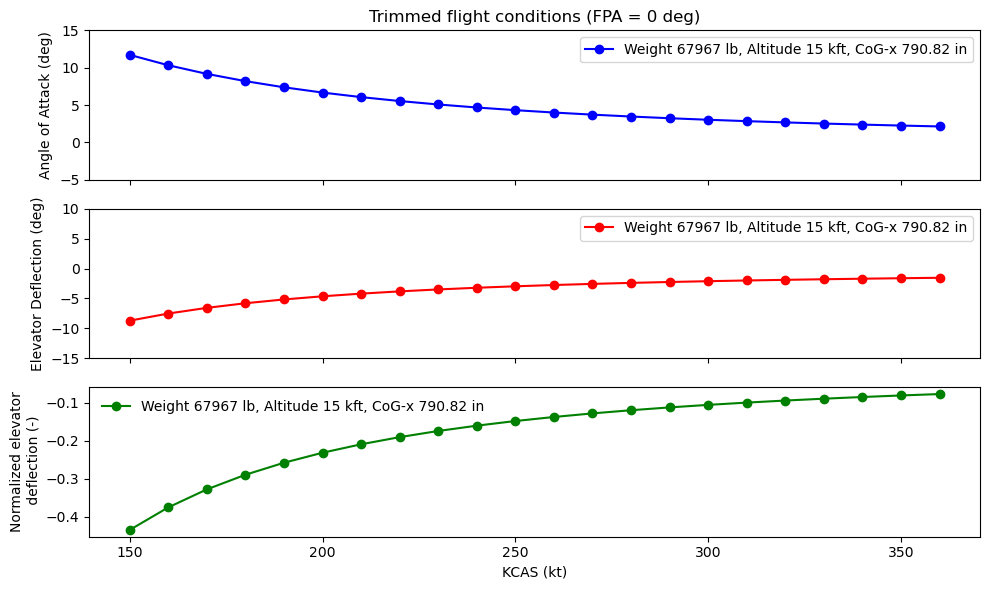

In [3]:
%matplotlib inline
# Fuel max for Global5000, lbm
fuelmax = 8097.63

# Instantiate the FDMExec object and load the aircraft
fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)
fdm.load_model(AIRCRAFT_NAME)

ac_xml_tree = ET.parse(os.path.join(fdm.get_root_dir(), f'aircraft/{AIRCRAFT_NAME}/{AIRCRAFT_NAME}.xml'))
ac_xml_root = ac_xml_tree.getroot()

# Get the empty weight from aircraft xml [assume lbs]
for x in ac_xml_root.findall('mass_balance'):
        w = x.find('emptywt').text

empty_weight = float(w)

# Get the original CG from aircraft xml, assum inches from Construction axes origin
for loc in ac_xml_root.findall('mass_balance/location'):
        x_cg_ = loc.find('x').text

x_cg_0 = float(x_cg_)

# Assume a payload, midweight, lb
payload_0 = 15172/2

# Assume the mass of fuel, half tanks, lb
fuel_per_tank = fuelmax/2

# Assume a flight altitude
h_ft_0 = 15000

weight_0 = empty_weight + payload_0 + fuel_per_tank*3

# Assume a zero flight path angle, gamma_0
gamma_0 = 0

print("-----------------------------------------")
print("Altitude {} ft, Weight {} lb, CoG-x {} in".format(h_ft_0, weight_0, x_cg_0))
print("-----------------------------------------")

# Run the simulation varying speed
speed_cas_1 = 90
speed_cas_2 = 550

print("Running simulation in the CAS range {} to {} kts".format(speed_cas_1, speed_cas_2))

# Set engines running
fdm['propulsion/set-running'] = -1

results = []
results_fcs = []

# Prepare two stacked subplots (AoA and elevator deflection)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Run for different speeds
for speed in range(speed_cas_1, speed_cas_2, 10):
    fdm['ic/h-sl-ft'] = h_ft_0
    fdm['ic/vc-kts'] = speed
    fdm['ic/gamma-deg'] = gamma_0
    fdm['propulsion/tank[0]/contents-lbs'] = fuel_per_tank
    fdm['propulsion/tank[1]/contents-lbs'] = fuel_per_tank
    fdm['propulsion/tank[2]/contents-lbs'] = fuel_per_tank
    fdm['inertia/pointmass-weight-lbs[0]'] = payload_0

    # Initialize the aircraft with initial conditions
    fdm.run_ic()
    # Run fdm model
    fdm.run()

    # Trim
    try:
        fdm['simulation/do_simple_trim'] = 1
        results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg']))
        results_fcs.append((fdm['velocities/vc-kts'], fdm['fcs/elevator-pos-rad'], fdm['fcs/elevator-pos-norm']))
    except jsbsim.TrimFailureError:
        pass  # Ignore trim failure exceptions

# Plot results
speed, alpha = zip(*results)
speed, dElev_rad, dElev_norm = zip(*results_fcs)
dElev_deg = [d * 180 / 3.14159 for d in dElev_rad]

# Plot AoA vs KCAS
ax1.plot(speed, alpha,
         label="Weight {0:.0f} lb, Altitude {1:.0f} kft, CoG-x {2:.2f} in".format(weight_0, h_ft_0/1000, x_cg_0),
         marker='o', linestyle='-', color='blue')

ax1.set_title("Trimmed flight conditions (FPA = {0:.0f} deg)".format(gamma_0))
ax1.set_ylabel('Angle of Attack (deg)')
ax1.set_ylim(-5, 15)
ax1.legend(loc='upper right')

# Plot elevator deflection vs KCAS
ax2.plot(speed, dElev_deg,
         label="Weight {0:.0f} lb, Altitude {1:.0f} kft, CoG-x {2:.2f} in".format(weight_0, h_ft_0/1000, x_cg_0),
         marker='o', linestyle='-', color='red')

#ax2.set_title("Trimmed flight conditions (FPA = {0:.0f} deg) - Elevator Deflection vs KCAS".format(gamma_0))
ax2.set_ylabel("Elevator Deflection (deg)")
ax2.set_ylim(-15, 10)
ax2.legend(loc="upper right")

# Plot normalized elevator deflection vs KCAS
ax3.plot(speed, dElev_norm,
         label="Weight {0:.0f} lb, Altitude {1:.0f} kft, CoG-x {2:.2f} in".format(weight_0, h_ft_0/1000, x_cg_0),
         marker='o', linestyle='-', color='green')

#ax3.set_title("Trimmed flight conditions (FPA = {0:.0f} deg) - Normalized elevator deflection vs KCAS".format(gamma_0))
ax3.legend(frameon=False)
ax3.set_ylabel("Normalized elevator\n deflection (-)")
ax3.set_xlabel("KCAS (kt)")

plt.tight_layout()
plt.show()

## Different aircraft weights, CoG positions and altitudes

Plots the variation in AoA versus CAS for level trim for different
aircraft weights, cg and altitude.

Calculation required for aircraft icing engineering.

-----------------------------------------
Restored CoG-x 790.82 in
-----------------------------------------


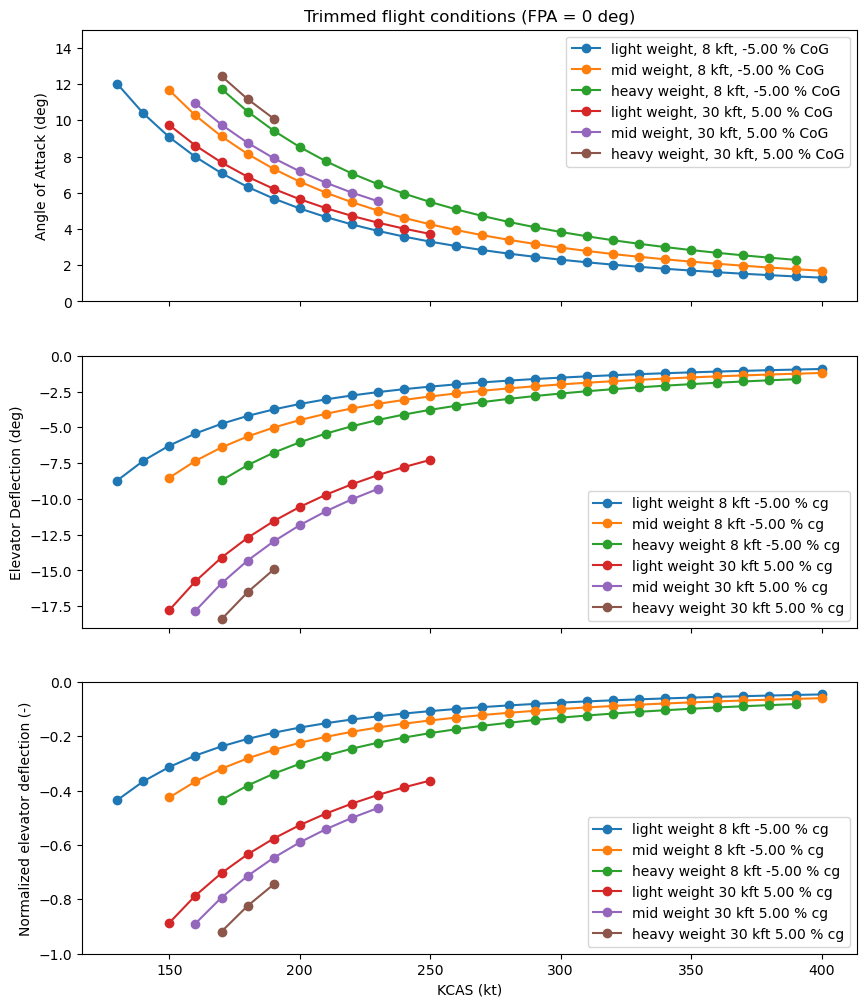

In [4]:
# Control whether to print results to console in addition to generating a plot
print_output = False

# Function to change CG in aircraft xml. Change the directory to the aircraft to be studied.
# Note - Moments of inertia are not updated.
# Input x_cg is a float. Returns a float.
def changeCG(fdm, x_cg, readOnly):
    tree = ET.parse(os.path.join(fdm.get_root_dir(), f'aircraft/{AIRCRAFT_NAME}/{AIRCRAFT_NAME}.xml'))
    root = tree.getroot()

    for loc in root.findall('mass_balance/location'):
        x = loc.find('x').text
        if not readOnly:
             loc.find('x').text = str(x_cg) # replace with the new value
             # Save the modified XML back to the file
             tree.write(os.path.join(fdm.get_root_dir(), f'aircraft/{AIRCRAFT_NAME}/{AIRCRAFT_NAME}.xml'))
             # return the same value
             x = str(x_cg)
    return float(x)

# Fuel max for Global5000
fuelmax = 8097.63

# Assume a zero flight path angle, gamma_0
gamma_0 = 0

# Prepare subplots to overlay plots
# Prepare two stacked subplots (AoA and elevator deflection)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Define here the payloads to be studied
payload = [1500, 15172/2, 15172]

# Define here the mass of fuel (per tank)
fuel = [1000, fuelmax/2, fuelmax]

# Three cases for weight
weight = ["light", "mid", "heavy"]

fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)
fdm.load_model(f'{AIRCRAFT_NAME}')

# Get the original CG from aircraft xml
x_cg_Orig = changeCG(fdm, 0, True)

# Vary CG in the study
xs_cg = [x_cg_Orig*0.95, x_cg_Orig*1.05]

# Vary altitude
h_ft = [8000, 30000]

# Run the simulation varying CG, altitude, speed and total weight
fdm = []
# Run for different CG's
for j in range(2):
    fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)
    fdm.load_model(f'{AIRCRAFT_NAME}')

    # Set engines running
    fdm['propulsion/set-running'] = -1

    # Change CoG-x in the aircraft xml
    xcg_ = changeCG(fdm, xs_cg[j], False)

    # Run for different weights
    for i in range(3):
        results = []
        results_fcs = []

        # Run for different speeds
        for speed in range(90, 550, 10):
            fdm['ic/h-sl-ft'] = h_ft[j]
            fdm['ic/vc-kts'] = speed
            fdm['ic/gamma-deg'] = gamma_0
            fdm['propulsion/tank[0]/contents-lbs'] = fuel[i]
            fdm['propulsion/tank[1]/contents-lbs'] = fuel[i]
            fdm['propulsion/tank[2]/contents-lbs'] = fuel[i]
            fdm['inertia/pointmass-weight-lbs[0]'] = payload[i]

            # Initialize the aircraft with initial conditions
            fdm.run_ic()
            # Run fdm model
            fdm.run()

            # Trim
            try:
                fdm['simulation/do_simple_trim'] = 1
                results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg']))
                results_fcs.append((fdm['velocities/vc-kts'], fdm['fcs/elevator-pos-rad'], fdm['fcs/elevator-pos-norm']))
            except jsbsim.TrimFailureError:
                pass  # Ignore trim failure exceptions

        if print_output:
            print("-----------------------------------------")
            print("Altitude {} - Weight {} - CG {}".format(h_ft[j], weight[i], xs_cg[j]))
            print("-----------------------------------------")
            print("KCAS, AoA (deg)")
            for result in results:
                print(result[0], result[1])

            print("---------")
            print("KCAS, Elevator deflection (rad), Normalized elevator deflection (-1 to 1)")
            for result_fcs in results_fcs:
                print(result_fcs[0], result_fcs[1], result_fcs[2])

        speed, alpha = zip(*results)
        ax1.plot(speed, alpha,
                 label="{0} weight, {1:.0f} kft, {2:.2f} % CoG".format(weight[i], h_ft[j]/1000, (float(xs_cg[j])/float(x_cg_Orig)-1)*100),
                 marker='o', linestyle='-')

        speed, dElev_rad, dElev_norm = zip(*results_fcs)
        # Convert elevator deflection from radians to degrees
        dElev_deg = [d * 180 / 3.14159 for d in dElev_rad]

        ax2.plot(speed, dElev_deg,
                 label="{0} weight {1:.0f} kft {2:.2f} % cg".format(weight[i], h_ft[j]/1000, (float(xs_cg[j])/float(x_cg_Orig)-1)*100),
                 marker='o', linestyle='-')

        ax3.plot(speed, dElev_norm,
                 label="{0} weight {1:.0f} kft {2:.2f} % cg".format(weight[i], h_ft[j]/1000, (float(xs_cg[j])/float(x_cg_Orig)-1)*100),
                marker='o', linestyle='-')

# Restore original CG for the aircraft xml
x_cg__ = changeCG(fdm," {:.2f} ".format(x_cg_Orig), False)

print("-----------------------------------------")
print("Restored CoG-x {} in".format(x_cg__))
print("-----------------------------------------")

# Plot final results

ax1.set_title("Trimmed flight conditions (FPA = {0:.0f} deg)".format(gamma_0))
ax1.set_ylabel("Angle of Attack (deg)")
ax1.legend(frameon=False)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 15)

ax2.set_ylabel('Elevator Deflection (deg)')
ax2.legend(frameon=False)
ax2.legend(loc='lower right')
ax2.set_ylim(-19, 0)

ax3.set_ylabel("Normalized elevator deflection (-)")
ax3.set_xlabel("KCAS (kt)")
ax3.legend(frameon=False)
ax3.legend(loc='lower right')
ax3.set_ylim(-1, 0)

plt.show()